#### Импортируем все необходимые библиотеки. Также определяем путь директории, чтобы  питон понимал, где находятся картинки для обучения/тестирования

In [1]:
import numpy as np
import PIL.Image as img
from pathlib import Path
import matplotlib.pyplot as plt
working_dir = Path().resolve()
print(working_dir)

C:\Users\Vexrina\Desktop\projects\neuron_labs


#### Объявляем класс Neuron, который содержит следующие функции:

1. init : активируется при инициализации класса. Определяются следующие поля: *weights, name, speed, thetta*
    - *weights* - определяются с помощью функции **np.random.uniform** в промежутке x<|3*10^-N|, где N подбирается вручную от 1 до 10, чтобы получить лучшую опредеяемость картинки. Так же это матрица размерностью 32 на 32, чтобы одно значение матрицы соответствовало одному значению пикселя.
    - *name* - буква, которую нейрон будет определять.
    - *speed* - скорость обучения. Если не передана в класс, то определяется рандомом от 0.05 до 1 *(методичка)*
    - *thetta* - пороговое значение функции. Если не передано значение, то определяется рандомом от 0.05 до 1. (в методичке это не указано, поэтому выбрал значения сам)
2. activation : функция активации, проверяет, что переданное значение sum больше, чем пороговое значение функции.
3. learn : высчитывает сумму произведения матрицы весов на переданную матрицу в функцию. Получаем булевое значение функции активации. В зависимости от условий (булевое значение и какое имя буквы передается) изменяются веса.
4. testing :  высчитывает сумму произведения матрицы весов на переданную матрицу в функцию. В зависимости от функции активации возвращает True или False

In [2]:
class Neuron:
    def __init__(
            self, name: str,
            thetta: float = np.random.uniform(low=0.05, high=1),
            speed: float = np.random.uniform(low=0.05, high=1)
    ):
        self.weights = np.random.uniform(low=-0.00003, high=0.00003, size=(32, 32))
        self.name = name
        self.speed = speed
        self.thetta = thetta

    def activation(self, sum):
        return sum >= self.thetta

    def learn(self, mtx, realname):
        summary = np.sum(self.weights.dot(mtx))
        activate = self.activation(summary)
        if activate and self.name != realname:
            self.weights -= np.dot(self.speed, mtx)  # error 0-1=-1
        elif not activate and self.name == realname:
            self.weights += np.dot(self.speed, mtx)  # error 1-0=+1
        # if error 1-1=0 (want 1, result 1) we cant create new weights, bc error = 0, so
        # secont multi = speed*0*weight = 0.

    def testing(self, mtx):
        summary = np.sum(self.weights.dot(mtx))
        if self.activation(summary):
            return True
        else:
            return False


#### Объявляем класс Network со следующими функциями:

1. init : объявляются все необходимые поля для работы класса, а именно:
    - *letters* : какие буквы будут определятся нейронной сетью, т.к. эти буквы надо было выбрать самостоятельно, то я выбрал *q,h,i,w*
    - *letters_data* : матрица Tuple'ов, где каждый элемент матрицы - RGBA, т.е. значения RGB пикселя + прозрачность пикселя
    - *letters_mtxs* : матрица для самих значений пикселя. Я решил, что надо брать только сугубо черные пиксели, т.е. чтобы RGB = 0, а A = 255.
    - *epoch* : количество эпох переданных в сеть. По стандарту = 50.
    - *neurons* : список с нейронами для обучения. В них передается speed и thetta. Если они не были переданы в класс, то создаются так же как и в классе Neuron
2. take_datas : Перевод всех изображений в матрицу и сохранений всех матриц в отдельный массив
3. tuples_to_mtx : Конвентирует массив тюплов в матрицу, где ТОЛЬКО черный цвет с alpha=255 - единица, а любое другое значение - 0.
4. show_weights : показывает как выглядит нейрон на данный момент времени.
5. train : по количеству эпох, для каждой из 4х картинок одной буквы, для каждого нейрона происходит вызов функции Neuron.learn()
6. test : перевод тестовых картинок в матрицу, прогон каждой картинки в neuron.test(), а так же вывод, это *"letter"* или это НЕ *"letter"*

In [3]:
class Network():
    def __init__(
            self,
            speed: float = np.random.uniform(low=0.05, high=1),
            thetta: float = np.random.uniform(low=0.05, high=1),
            epoch: int = 50
    ):
        self.letters = ['q', 'h', 'i', 'w']
        self.letters_data = []
        self.mtxs = []
        self.take_datas()
        for data in self.letters_data:
            self.mtxs.append(self.tuples_to_mtx(data))
        self.epoch = epoch
        self.neurons = [Neuron(letter, thetta=thetta, speed=speed)
                        for letter in self.letters]
        print(f'Настройки:\nКол-во эпох - {epoch}\nСкорость - {speed}')

    def take_datas(self):
        for letter in self.letters:
            for i in range(4):  # 4 - количество образов буквы
                file_name = f'letters/{letter}{i+1}.png'
                image = img.open(working_dir/file_name)
                data = image.convert('RGBA').getdata()
                self.letters_data.append(data)

    def tuples_to_mtx(self, data):
        result = [[]]
        i, j = 0, 0
        for item in data:
            if j == 32:
                result.append([])
                i += 1
                j = 0
            if item[0] == 0 and item[1] == 0 and item[2] == 0 and item[3] == 255:
                result[i].append(1)
                j += 1
            else:
                result[i].append(0)
                j += 1
        return result

    def show_weights(self):
        for i, l in enumerate(self.letters):
            print(f'Neuron {l}:')
            plt.imshow(self.neurons[i].weights)
            plt.show()

    def train(self):
        for __ in range(self.epoch):
            # q
            for index in range(4):
                for neuron in self.neurons:
                    neuron.learn(self.mtxs[index], self.letters[0])
            # h
            for index in range(4, 8):
                for neuron in self.neurons:
                    neuron.learn(self.mtxs[index], self.letters[1])
            # i
            for index in range(8, 12):
                for neuron in self.neurons:
                    neuron.learn(self.mtxs[index], self.letters[2])
            # w
            for index in range(12, 16):
                for neuron in self.neurons:
                    neuron.learn(self.mtxs[index], self.letters[3])

    def test(self):
        datas = []
        for letter in self.letters:
            file_name = f'letters/{letter}_test.png'
            image = img.open(working_dir/file_name)
            datas.append(image.convert('RGBA').getdata())
            
        self.test_pic = []
        for data in datas:
            result = [[]]
            i, j = 0, 0
            for item in data:
                if j == 32:
                    result.append([])
                    i += 1
                    j = 0
                if item[0] == 0 and item[1] == 0 and item[2] == 0 and item[3] == 255:
                    result[i].append(1)
                    j += 1
                else:
                    result[i].append(0)
                    j += 1
            self.test_pic.append(result)
        
        k = 0
        for pic in self.test_pic:
            print(f'THIS WAS A {self.letters[k]}')
            print('Network result:')
            for neuron in self.neurons:
                if neuron.testing(pic):
                    print(f'This is {neuron.name}')
                else:
                    print(f'This isnot {neuron.name}')
            print()
            k+=1


#### Инициализируется нейронная сеть нейронная сеть

In [12]:
network = Network(0.01, 0.5, 100)

Настройки:
Кол-во эпох - 100
Скорость - 0.01


#### Запускается тренировка нейронной сети и выводятся веса

Neuron q:


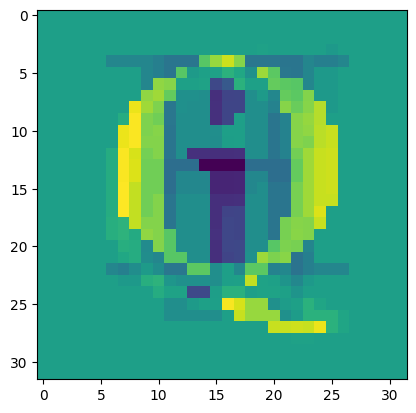

Neuron h:


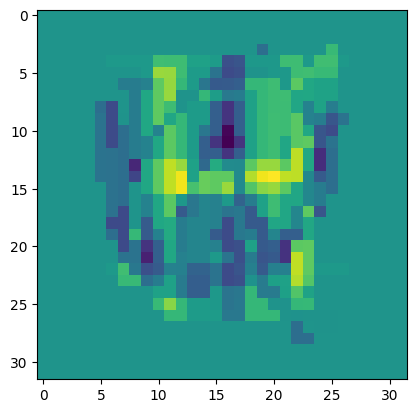

Neuron i:


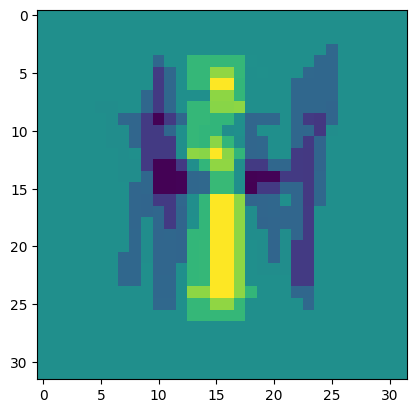

Neuron w:


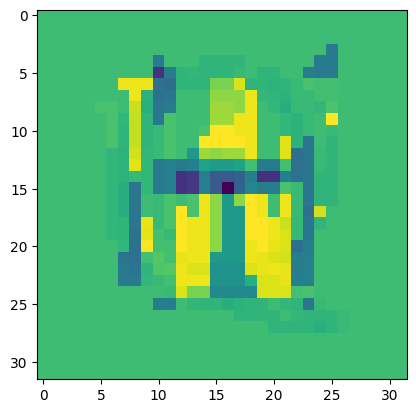

In [13]:
network.train()
network.show_weights()

#### Проверка работы нейронной сети.

In [9]:
network.test()

THIS WAS A q
Network result:
This is q
This is h
This isnot i
This isnot w

THIS WAS A h
Network result:
This isnot q
This is h
This isnot i
This is w

THIS WAS A i
Network result:
This isnot q
This isnot h
This is i
This isnot w

THIS WAS A w
Network result:
This isnot q
This isnot h
This isnot i
This isnot w



### Вывод.
#### В ходе выполнения данной лабораторной работы, я научился реализовывать Обучение однослойного персептрона методом коррекции по ошибке через дельта-правило. Проверка на разных test картинках показало, что точность определения составила около 80%.